<a href="https://colab.research.google.com/github/bmoretz/MSDS-MachineLearning/blob/master/Assignment_05/Assignment_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries & Standard Setup

In [266]:
!pip install jupyterthemes

In [0]:
%matplotlib inline

import os

# Core
import pandas as pd
import numpy as np

# Visuals
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# jt themes
from jupyterthemes import jtplot

# IPython display
from IPython.display import display

from scipy.io import loadmat # for loading .MAT files
import urllib.request

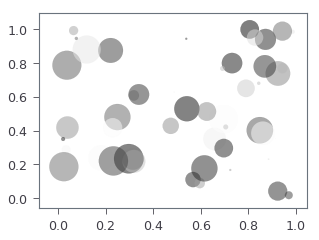

In [268]:
# Test Theme
!jt -t grade3 -f fira -fs 115
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Looks good. Let's roll.

In [0]:
# santatize Dataset
def santatize_set( dataframe ):
    if dataframe.isnull().values.any() == True:
        cleaned = dataframe.dropna()
        print('Dropped {} invalid samples'.format(dataframe.count - cleaned.count))
        dataframe = cleaned
    return dataframe

In [0]:
# saves a plot for reporting later. 
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Utility

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [0]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

# Dataset

This 'homebrew' method is the only way I could reliably get MNIST data. The 'fetch_mldata' literally works 1 / 50 tries.

In [0]:
from six.moves import urllib

from scipy.io import loadmat
mnist_alternative_url = "https://raw.githubusercontent.com/bmoretz/MSDS-MachineLearning/master/datasets/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}

In [0]:
X, y = mnist['data'], mnist['target']

In [275]:
X.shape

(70000, 784)

In [276]:
y.shape

(70000,)

# Exploration

Let's grab a random image and inspect it.

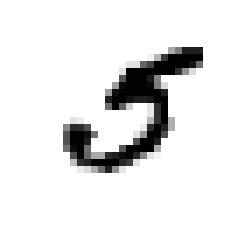

In [277]:
some_digit = X[36000]
plot_digit(some_digit)

Let's grab a few more random images and display a grid so we can get a sense of the overall structure.

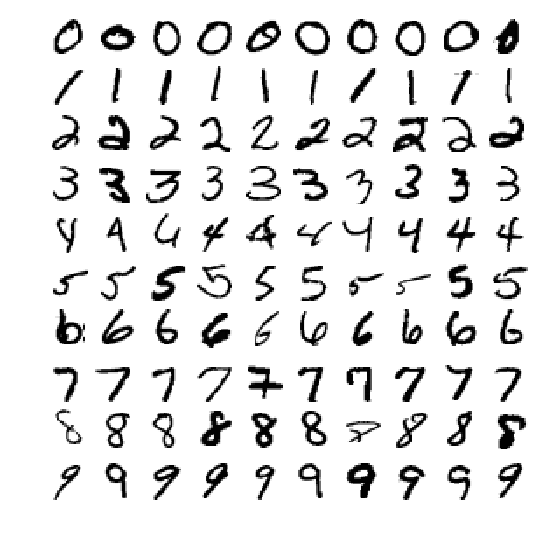

In [278]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

# Prepare Model Data

Split the data to 60,000 images as training data and 10,000 as test data.

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rf_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, n_jobs=-1)

# Random Forest, Performance Benchmark

Let's repeat the trial ten times, and record  the results.

In [0]:
import time

In [0]:
np.random.seed(seed = 42) # fix seed so we can reproduce.

In [0]:
x_time = [] # empty list for storing test results
n = 0  # initialize count

In [0]:
while (n < replications): 
    start_time = time.clock()
    # generate 1 million random negative binomials and store in a vector
    rf_clf.fit(X_train, y_train)
    end_time = time.clock()
    runtime = end_time - start_time  # seconds of wall-clock time
    x_time.append(runtime * 1000)  # report in milliseconds 
    n = n + 1

In [286]:
pd.options.display.float_format = '{:,}'.format # pretty display format
rf_fit_times = pd.DataFrame(x_time, columns=['time']) # save results
rf_fit_times.describe().round(2)

,time
count,10.0
mean,"30,487.75"
std,273.94
min,"29,918.32"
25%,"30,363.82"
50%,"30,551.69"
75%,"30,619.67"
max,"30,918.09"


# Prediction Accuracy

In [287]:
from sklearn.metrics import f1_score

y_predict = rf_clf.predict(X_test)
rf_f1Score = f1_score(y_test, y_predict, average='weighted')

display('F1 Score: {:.4f}'.format(rf_f1Score))

'F1 Score: 0.7642'

# Principal Component Analysis

In [0]:
from sklearn.decomposition import PCA

Generate principal components that represent 95 percent of the variability in the explanatory variables.

In [0]:
pca = PCA(n_components=0.95)

Runtime to identify the principal components.

# Principal Component Analysis, Performance Benchmark

In [0]:
pca_time = [] # empty list for storing test results
n = 0  # initialize count

Time to Identify Pricipal Components

In [0]:
while (n < replications): 
    start_time = time.clock()
    # generate 1 million random negative binomials and store in a vector
    X_pca = pca.fit_transform(X) # run on all 70,000 observations
    end_time = time.clock()
    runtime = end_time - start_time  # seconds of wall-clock time
    pca_time.append(runtime * 1000)  # report in milliseconds 
    n = n + 1

In [292]:
pca_fit_times = pd.DataFrame(pca_time, columns=['time']) # save results
pca_fit_times.describe().round(2)

,time
count,10.0
mean,"31,061.41"
std,"1,052.88"
min,"30,431.46"
25%,"30,492.06"
50%,"30,589.6"
75%,"30,792.92"
max,"33,465.4"


# Explained Variance

In [293]:
pca_explained_variance = pca.explained_variance_ratio_

explained_variance = pd.DataFrame(pca_explained_variance, columns=['Explained Variance'])

explained_variance.describe().round(7)

,Explained Variance
count,154.0
mean,0.0061711
std,0.0132526
min,0.0004495
25%,0.0007517
50%,0.0015786
75%,0.0047611
max,0.0974612


In [294]:
display( '{}'.format(explained_variance.sum().round(4) * 100))

'Explained Variance   95.03\ndtype: float64'

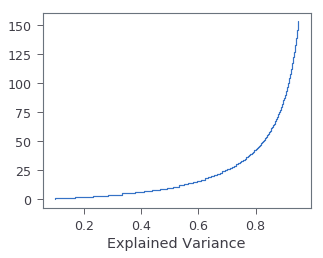

In [295]:
explained_variance.reset_index().plot.line(explained_variance['Explained Variance'].cumsum(), 'index', drawstyle='steps', legend = False)
plt.show()

# Random Forest with Principal Components

Split the reduced data to 60,000 images as training data and 10,000 as test data.

In [0]:
X_pca_train, X_pca_test = X_pca[:60000], X_pca[60000:]

In [0]:
rf_clf_pca = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, n_jobs=-1)

Runtime to identify the principal components.

In [0]:
x_pca_time = [] # empty list for storing test results
n = 0  # initialize count

Time to Fit Random Forest Classifier using Principal Components.

In [0]:
while (n < replications): 
    start_time = time.clock()
    # generate 1 million random negative binomials and store in a vector
    rf_clf_pca.fit(X_pca_train, y_train)
    end_time = time.clock()
    runtime = end_time - start_time  # seconds of wall-clock time
    x_pca_time.append(runtime * 1000)  # report in milliseconds
    n = n + 1

In [184]:
x_pca_fit_times = pd.DataFrame(x_pca_time, columns=['time']) # save results
x_pca_fit_times.describe().round(2)

,time
count,10.0
mean,"56,922.6"
std,"1,358.6"
min,"54,925.87"
25%,"56,014.63"
50%,"56,858.76"
75%,"57,710.62"
max,"59,103.47"


# Random Forest with Principal Componenets, Prediction

In [0]:
y_predict_pca = rf_clf_pca.predict(X_pca_test)

In [186]:
pca_f1Score = f1_score(y_test, y_predict_pca, average='weighted')

display('PCA F1 Score: {:.4f}'.format(pca_f1Score))

'PCA F1 Score: 0.7726'

# Summary Comparison

In [0]:
combined = pd.concat( [rf_fit_times, pca_fit_times, x_pca_fit_times], axis = 1)
combined.columns = ['Random Forest', 'PCA', 'RF + PCA']

In [261]:
combined.mean().round(0)

Random Forest   32,090.0
PCA             31,942.0
RF + PCA        56,923.0
dtype: float64

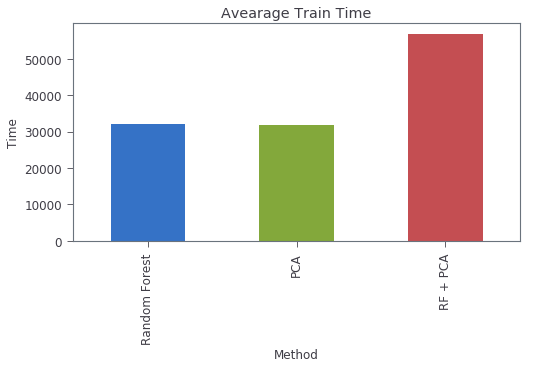

In [265]:
ax = combined.mean().plot(kind='bar', title ="Avearage Train Time", figsize=(8, 4), legend=False, fontsize=12)
ax.set_xlabel("Method", fontsize=12)
ax.set_ylabel("Time", fontsize=12)
plt.show()

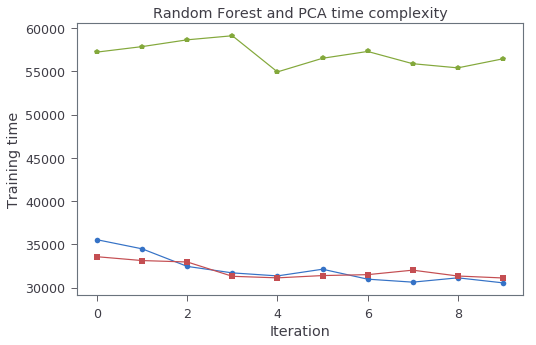

In [251]:
sizes = list(range(0, len(combined)))

plt.rcParams["figure.figsize"] = [8, 5]

plt.plot(sizes, rf_fit_times, "b-o", label="Random Forest")
plt.plot(sizes, pca_fit_times, "r-s", label="PCA")
plt.plot(sizes, x_pca_fit_times, "g-p", label="PCA + RF")

plt.xlabel("Iteration")
plt.ylabel("Training time")
plt.title("Random Forest and PCA time complexity")

plt.show()